In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras as tf_keras

import os
import shutil
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.applications import ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
from tensorflow.keras.mixed_precision import set_global_policy, LossScaleOptimizer

### 온라인 학습

In [14]:
# 모델 설계 함수
def create_model(input_shape=(256, 256, 3), num_classes=150):
    base_model = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)

    # Conv1 ~ Conv3 freeze, Conv4 ~ Conv5 학습
    for layer in base_model.layers[:143]:
        layer.trainable = False

    for layer in base_model.layers[143:]:
        layer.trainable = True

    # 완전 연결층 추가
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)  # 150개의 클래스

    model = tf.keras.models.Model(inputs=base_model.input, outputs=x)
    
    # 모델 컴파일
    optimizer = SGD(learning_rate=0.01, momentum=0.9, decay=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [15]:
# 콜백 설정 함수
def get_callbacks(model_save_path='D:/Work/3rd_pj/k_food_datasets/model_best.keras'):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    
    return [early_stopping, checkpoint, reduce_lr]

In [16]:
# 데이터 제너레이터 함수
def get_data_generators(dataset_dir, target_size=(256, 256), batch_size=16):
    # ImageDataGenerator 설정
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_generator = train_datagen.flow_from_directory(
        f"{dataset_dir}/train",
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_directory(
        f"{dataset_dir}/validation",
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        f"{dataset_dir}/test",
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, val_generator, test_generator

In [20]:
# 모델 훈련 및 평가 함수
def train_and_evaluate_model(model, train_generator, val_generator, test_generator, 
                             callbacks, epochs=30, batch_size=16):
    # 모델 훈련
    model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size,
        callbacks=callbacks
    )

    # 테스트 데이터로 성능 평가
    test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
    return test_acc

In [21]:
# 전체 학습 함수
def run_training_on_datasets(base_dir, dataset_from, dataset_to, initial_model_path='../model/best_model_with_rn101.keras'):
    # 모델이 주어지지 않으면 새로 생성, 또는 기존에 저장된 모델 불러오기
    if os.path.exists(initial_model_path):
        model = load_model(initial_model_path)  # 기존에 저장된 모델을 불러옴
        print(f"Loaded model from {initial_model_path}")
    else:
        model = create_model()  # 처음부터 모델을 새로 생성
        print("No existing model found, creating a new one.")

    # 지정한 범위 내 데이터셋만 학습
    for i in range(dataset_from, dataset_to):
        dataset_dir = f"{base_dir}/dataset{i}"
        
        # 모델 저장 경로 (최고 성능 모델을 이 파일에 저장)
        model_save_path = initial_model_path  # 경로와 이름을 그대로 사용
        
        # 콜백 설정
        callbacks = get_callbacks(model_save_path)
        
        # 데이터 제너레이터 생성
        train_generator, val_generator, test_generator = get_data_generators(dataset_dir)
        
        # 모델 훈련 및 성능 평가
        test_acc = train_and_evaluate_model(model, train_generator, val_generator, test_generator, callbacks)
        
        print(f"Dataset {i} - Test accuracy: {test_acc}")

    return model  # 학습이 끝난 모델을 반환

In [ ]:
# 첫날 학습
best_model_day1 = run_training_on_datasets(
    base_dir='../../../k_food_datasets', 
    dataset_from=0, 
    dataset_to=2
)

c:\Users\human\.conda\envs\colab\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


No existing model found, creating a new one.
Found 21000 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.


c:\Users\human\.conda\envs\colab\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0076 - loss: 5.6983
Epoch 1: val_loss improved from inf to 4.83258, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6706s 5s/step - accuracy: 0.0076 - loss: 5.6981 - val_accuracy: 0.0116 - val_loss: 4.8326 - learning_rate: 0.0100
Epoch 2/15
   1/1312 ━━━━━━━━━━━━━━━━━━━━ 1:39:29 5s/step - accuracy: 0.0000e+00 - loss: 4.9045

c:\Users\human\.conda\envs\colab\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 4.83258 to 4.83192, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 478s 361ms/step - accuracy: 0.0000e+00 - loss: 4.9045 - val_accuracy: 0.0111 - val_loss: 4.8319 - learning_rate: 0.0100
Epoch 3/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0145 - loss: 4.8225
Epoch 3: val_loss did not improve from 4.83192
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6209s 5s/step - accuracy: 0.0145 - loss: 4.8224 - val_accuracy: 0.0309 - val_loss: 4.8342 - learning_rate: 0.0100
Epoch 4/15
   1/1312 ━━━━━━━━━━━━━━━━━━━━ 1:36:28 4s/step - accuracy: 0.0000e+00 - loss: 4.6935
Epoch 4: val_loss did not improve from 4.83192
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 463s 350ms/step - accuracy: 0.0000e+00 - loss: 4.6935 - val_accuracy: 0.0309 - val_loss: 4.8530 - learning_rate: 0.0100
Epoch 5/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0260 - loss: 4.4706
Epoch 5: val_loss improved from 4.83192 to 4.12353, saving model to ../model/best_m

In [7]:
# 두번째 날 학습 (기존의 베스트 모델 불러오기)
best_model_day2 = run_training_on_datasets(
    base_dir='../../../k_food_datasets',
    dataset_from=1,
    dataset_to=2,
    initial_model_path='../model/best_model_with_rn101.keras'  # 이전에 저장된 모델 불러오기
)

Loaded model from ../model/best_model_with_rn101.keras
Found 21000 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.


c:\Users\human\.conda\envs\colab\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3753 - loss: 2.3215
Epoch 1: val_loss improved from inf to 1.81550, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6226s 5s/step - accuracy: 0.3753 - loss: 2.3215 - val_accuracy: 0.5122 - val_loss: 1.8155 - learning_rate: 0.0100
Epoch 2/15
   1/1312 ━━━━━━━━━━━━━━━━━━━━ 1:33:31 4s/step - accuracy: 0.5000 - loss: 2.3280

c:\Users\human\.conda\envs\colab\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 1.81550 to 1.81311, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 468s 354ms/step - accuracy: 0.5000 - loss: 2.3280 - val_accuracy: 0.5125 - val_loss: 1.8131 - learning_rate: 0.0100
Epoch 3/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4507 - loss: 2.0064
Epoch 3: val_loss improved from 1.81311 to 1.62616, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6101s 5s/step - accuracy: 0.4507 - loss: 2.0064 - val_accuracy: 0.5614 - val_loss: 1.6262 - learning_rate: 0.0100
Epoch 4/15
   1/1312 ━━━━━━━━━━━━━━━━━━━━ 1:31:18 4s/step - accuracy: 0.4375 - loss: 2.1665
Epoch 4: val_loss did not improve from 1.62616
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 469s 355ms/step - accuracy: 0.4375 - loss: 2.1665 - val_accuracy: 0.5616 - val_loss: 1.6288 - learning_rate: 0.0100
Epoch 5/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5173 - loss: 1.7296
Epoch 5: val_loss improved from 1.626

In [8]:
# 세번째 날 학습 (기존의 베스트 모델 불러오기)
best_model_day3 = run_training_on_datasets(
    base_dir='../../../k_food_datasets',
    dataset_from=2,
    dataset_to=3,
    initial_model_path='../model/best_model_with_rn101.keras'  # 이전에 저장된 모델 불러오기
)

Loaded model from ../model/best_model_with_rn101.keras
Found 21000 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.


c:\Users\human\.conda\envs\colab\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4479 - loss: 2.2937
Epoch 1: val_loss improved from inf to 1.37227, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6286s 5s/step - accuracy: 0.4479 - loss: 2.2935 - val_accuracy: 0.6259 - val_loss: 1.3723 - learning_rate: 0.0050
Epoch 2/15
   1/1312 ━━━━━━━━━━━━━━━━━━━━ 1:36:28 4s/step - accuracy: 0.4375 - loss: 2.9725

c:\Users\human\.conda\envs\colab\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 1.37227
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 460s 348ms/step - accuracy: 0.4375 - loss: 2.9725 - val_accuracy: 0.6252 - val_loss: 1.3727 - learning_rate: 0.0050
Epoch 3/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5715 - loss: 1.5536
Epoch 3: val_loss did not improve from 1.37227
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6096s 5s/step - accuracy: 0.5715 - loss: 1.5536 - val_accuracy: 0.6210 - val_loss: 1.3816 - learning_rate: 0.0050
Epoch 4/15
   1/1312 ━━━━━━━━━━━━━━━━━━━━ 1:32:50 4s/step - accuracy: 0.3125 - loss: 2.3637
Epoch 4: val_loss did not improve from 1.37227
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 456s 345ms/step - accuracy: 0.3125 - loss: 2.3637 - val_accuracy: 0.6208 - val_loss: 1.3805 - learning_rate: 0.0050
Epoch 5/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6502 - loss: 1.2152
Epoch 5: val_loss did not improve from 1.37227
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6053s 5s/step - accuracy: 0.6502 - loss: 1.2152 - val_accuracy: 0.6161 - va

In [9]:
# 4번째 날 학습 (기존의 베스트 모델 불러오기)
best_model_day4 = run_training_on_datasets(
    base_dir='../../../k_food_datasets',
    dataset_from=3,
    dataset_to=4,
    initial_model_path='../model/best_model_with_rn101.keras'  # 이전에 저장된 모델 불러오기
)

Loaded model from ../model/best_model_with_rn101.keras
Found 21000 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.


c:\Users\human\.conda\envs\colab\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4838 - loss: 1.9577
Epoch 1: val_loss improved from inf to 1.32763, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6549s 5s/step - accuracy: 0.4838 - loss: 1.9577 - val_accuracy: 0.6312 - val_loss: 1.3276 - learning_rate: 0.0050
Epoch 2/15
   1/1312 ━━━━━━━━━━━━━━━━━━━━ 1:36:18 4s/step - accuracy: 0.4375 - loss: 1.7730

c:\Users\human\.conda\envs\colab\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 1.32763 to 1.32750, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 469s 354ms/step - accuracy: 0.4375 - loss: 1.7730 - val_accuracy: 0.6306 - val_loss: 1.3275 - learning_rate: 0.0050
Epoch 3/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5628 - loss: 1.5639
Epoch 3: val_loss improved from 1.32750 to 1.31480, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6692s 5s/step - accuracy: 0.5628 - loss: 1.5640 - val_accuracy: 0.6346 - val_loss: 1.3148 - learning_rate: 0.0050
Epoch 4/15
   1/1312 ━━━━━━━━━━━━━━━━━━━━ 1:45:32 5s/step - accuracy: 0.5625 - loss: 1.8617
Epoch 4: val_loss improved from 1.31480 to 1.31355, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 505s 382ms/step - accuracy: 0.5625 - loss: 1.8617 - val_accuracy: 0.6352 - val_loss: 1.3135 - learning_rate: 0.0050
Epoch 5/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0

In [10]:
# 5번째 날 학습 (기존의 베스트 모델 불러오기)
best_model_day5 = run_training_on_datasets(
    base_dir='../../../k_food_datasets',
    dataset_from=4,
    dataset_to=6,
    initial_model_path='../model/best_model_with_rn101.keras'  # 이전에 저장된 모델 불러오기
)

Loaded model from ../model/best_model_with_rn101.keras
Found 21000 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.


c:\Users\human\.conda\envs\colab\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5190 - loss: 1.8278
Epoch 1: val_loss improved from inf to 1.24370, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6180s 5s/step - accuracy: 0.5190 - loss: 1.8278 - val_accuracy: 0.6615 - val_loss: 1.2437 - learning_rate: 0.0050
Epoch 2/15
   1/1312 ━━━━━━━━━━━━━━━━━━━━ 1:36:34 4s/step - accuracy: 0.4375 - loss: 1.9475

c:\Users\human\.conda\envs\colab\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 1.24370
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 455s 344ms/step - accuracy: 0.4375 - loss: 1.9475 - val_accuracy: 0.6613 - val_loss: 1.2448 - learning_rate: 0.0050
Epoch 3/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5989 - loss: 1.4193
Epoch 3: val_loss improved from 1.24370 to 1.22720, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6134s 5s/step - accuracy: 0.5989 - loss: 1.4193 - val_accuracy: 0.6581 - val_loss: 1.2272 - learning_rate: 0.0050
Epoch 4/15
   1/1312 ━━━━━━━━━━━━━━━━━━━━ 1:37:22 4s/step - accuracy: 0.6250 - loss: 0.9612
Epoch 4: val_loss did not improve from 1.22720
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 463s 350ms/step - accuracy: 0.6250 - loss: 0.9612 - val_accuracy: 0.6581 - val_loss: 1.2286 - learning_rate: 0.0050
Epoch 5/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6751 - loss: 1.1224
Epoch 5: val_loss did not improve from 1.22720
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6122s 5s/step - a

In [11]:
# 6번째 날 학습 (기존의 베스트 모델 불러오기)
best_model_day6 = run_training_on_datasets(
    base_dir='../../../k_food_datasets',
    dataset_from=6,
    dataset_to=8,
    initial_model_path='../model/best_model_with_rn101.keras'  # 이전에 저장된 모델 불러오기
)

Loaded model from ../model/best_model_with_rn101.keras
Found 21000 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.
Epoch 1/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5965 - loss: 1.5135
Epoch 1: val_loss improved from inf to 0.96269, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6129s 5s/step - accuracy: 0.5965 - loss: 1.5135 - val_accuracy: 0.7260 - val_loss: 0.9627 - learning_rate: 0.0025
Epoch 2/15
   1/1312 ━━━━━━━━━━━━━━━━━━━━ 1:33:17 4s/step - accuracy: 0.5000 - loss: 2.2539
Epoch 2: val_loss did not improve from 0.96269
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 449s 339ms/step - accuracy: 0.5000 - loss: 2.2539 - val_accuracy: 0.7260 - val_loss: 0.9629 - learning_rate: 0.0025
Epoch 3/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6685 - loss: 1.1742
Epoch 3: val_loss improved from 0.96269 to 0.95593, saving model to ../model/best_model_with_rn101.keras
1

In [12]:
# 7번째 날 학습 (기존의 베스트 모델 불러오기)
best_model_day7 = run_training_on_datasets(
    base_dir='../../../k_food_datasets',
    dataset_from=8,
    dataset_to=10,
    initial_model_path='../model/best_model_with_rn101.keras'  # 이전에 저장된 모델 불러오기
)

Loaded model from ../model/best_model_with_rn101.keras
Found 21000 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.
Epoch 1/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6155 - loss: 1.4214
Epoch 1: val_loss improved from inf to 0.91524, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6065s 5s/step - accuracy: 0.6155 - loss: 1.4214 - val_accuracy: 0.7335 - val_loss: 0.9152 - learning_rate: 0.0012
Epoch 2/15
   1/1312 ━━━━━━━━━━━━━━━━━━━━ 1:32:12 4s/step - accuracy: 0.5625 - loss: 0.9799
Epoch 2: val_loss improved from 0.91524 to 0.91380, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 445s 337ms/step - accuracy: 0.5625 - loss: 0.9799 - val_accuracy: 0.7342 - val_loss: 0.9138 - learning_rate: 0.0012
Epoch 3/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6678 - loss: 1.1860
Epoch 3: val_loss improved from 0.91380 to 0.908

In [13]:
# 8번째 날 학습 (기존의 베스트 모델 불러오기)
best_model_day7 = run_training_on_datasets(
    base_dir='../../../k_food_datasets',
    dataset_from=0,
    dataset_to=1,
    initial_model_path='../model/best_model_with_rn101.keras'  # 이전에 저장된 모델 불러오기
)

Loaded model from ../model/best_model_with_rn101.keras
Found 21000 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.
Epoch 1/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6224 - loss: 1.3886
Epoch 1: val_loss improved from inf to 0.92480, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6415s 5s/step - accuracy: 0.6224 - loss: 1.3886 - val_accuracy: 0.7411 - val_loss: 0.9248 - learning_rate: 6.2500e-04
Epoch 2/15
   1/1312 ━━━━━━━━━━━━━━━━━━━━ 1:35:53 4s/step - accuracy: 0.5625 - loss: 1.9614
Epoch 2: val_loss improved from 0.92480 to 0.92296, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 467s 353ms/step - accuracy: 0.5625 - loss: 1.9614 - val_accuracy: 0.7418 - val_loss: 0.9230 - learning_rate: 6.2500e-04
Epoch 3/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6733 - loss: 1.1813
Epoch 3: val_loss improved from 0.92296 

In [14]:
# 9번째 날 학습 (기존의 베스트 모델 불러오기)
best_model_day7 = run_training_on_datasets(
    base_dir='../../../k_food_datasets',
    dataset_from=1,
    dataset_to=2,
    initial_model_path='../model/best_model_with_rn101.keras'  # 이전에 저장된 모델 불러오기
)

Loaded model from ../model/best_model_with_rn101.keras
Found 21000 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.
Epoch 1/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7498 - loss: 0.8574
Epoch 1: val_loss improved from inf to 0.94312, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6263s 5s/step - accuracy: 0.7498 - loss: 0.8573 - val_accuracy: 0.7411 - val_loss: 0.9431 - learning_rate: 6.2500e-04
Epoch 2/15
   1/1312 ━━━━━━━━━━━━━━━━━━━━ 1:36:55 4s/step - accuracy: 0.7500 - loss: 0.9336
Epoch 2: val_loss did not improve from 0.94312
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 458s 346ms/step - accuracy: 0.7500 - loss: 0.9336 - val_accuracy: 0.7413 - val_loss: 0.9433 - learning_rate: 6.2500e-04
Epoch 3/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8081 - loss: 0.6584
Epoch 3: val_loss did not improve from 0.94312
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6127s 5s/step - accu

In [15]:
# 10번째 날 학습 (기존의 베스트 모델 불러오기)
best_model_day7 = run_training_on_datasets(
    base_dir='../../../k_food_datasets',
    dataset_from=2,
    dataset_to=3,
    initial_model_path='../model/best_model_with_rn101.keras'  # 이전에 저장된 모델 불러오기
)

Loaded model from ../model/best_model_with_rn101.keras
Found 21000 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.
Epoch 1/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6545 - loss: 1.2665
Epoch 1: val_loss improved from inf to 0.93930, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6228s 5s/step - accuracy: 0.6545 - loss: 1.2665 - val_accuracy: 0.7369 - val_loss: 0.9393 - learning_rate: 6.2500e-04
Epoch 2/15
   1/1312 ━━━━━━━━━━━━━━━━━━━━ 1:38:32 5s/step - accuracy: 0.6250 - loss: 1.1542
Epoch 2: val_loss did not improve from 0.93930
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 457s 345ms/step - accuracy: 0.6250 - loss: 1.1542 - val_accuracy: 0.7362 - val_loss: 0.9401 - learning_rate: 6.2500e-04
Epoch 3/15
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7007 - loss: 1.0596
Epoch 3: val_loss improved from 0.93930 to 0.93840, saving model to ../model/best_model_with_rn101

In [ ]:
# 11번째 날 학습 (기존의 베스트 모델 불러오기)
best_model_day11 = run_training_on_datasets(
    base_dir='../../../k_food_datasets',
    dataset_from=0,
    dataset_to=10,
    initial_model_path='../model/best_model_with_rn101.keras'  # 이전에 저장된 모델 불러오기
)

Loaded model from ../model/best_model_with_rn101.keras
Found 21000 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.
Found 4500 images belonging to 150 classes.


c:\Users\human\.conda\envs\colab\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7710 - loss: 0.7729
Epoch 1: val_loss improved from inf to 0.89490, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6454s 5s/step - accuracy: 0.7710 - loss: 0.7729 - val_accuracy: 0.7424 - val_loss: 0.8949 - learning_rate: 3.9062e-05
Epoch 2/30
   1/1312 ━━━━━━━━━━━━━━━━━━━━ 1:40:29 5s/step - accuracy: 0.8750 - loss: 0.4717

c:\Users\human\.conda\envs\colab\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.89490 to 0.89433, saving model to ../model/best_model_with_rn101.keras
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 472s 357ms/step - accuracy: 0.8750 - loss: 0.4717 - val_accuracy: 0.7438 - val_loss: 0.8943 - learning_rate: 3.9062e-05
Epoch 3/30
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7884 - loss: 0.7217
Epoch 3: val_loss did not improve from 0.89433
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6386s 5s/step - accuracy: 0.7884 - loss: 0.7217 - val_accuracy: 0.7444 - val_loss: 0.8967 - learning_rate: 3.9062e-05
Epoch 4/30
   1/1312 ━━━━━━━━━━━━━━━━━━━━ 1:45:23 5s/step - accuracy: 0.8125 - loss: 0.5526
Epoch 4: val_loss did not improve from 0.89433
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 492s 372ms/step - accuracy: 0.8125 - loss: 0.5526 - val_accuracy: 0.7447 - val_loss: 0.8952 - learning_rate: 3.9062e-05
Epoch 5/30
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7840 - loss: 0.7209
Epoch 5: val_loss did not improve from 0.89433
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6468s

# 분류를 잘 못하는 클래스 확인하기

### 약식을 위한 dataset 생성

In [ ]:
import os
import shutil
import random

# 원본 데이터 경로와 생성할 데이터 경로 설정
original_dataset_dir = r"D:\Work\all_project\3rd_final_project\k_food_for_colab"    # test: class별 140장
test_dataset_dir = r"D:\Work\all_project\3rd_final_project\k_food_datasets\dataset_test"

# 폴더 생성 함수
def create_directory_structure(base_dir, class_names):
    for split in ["test"]:
        split_dir = os.path.join(base_dir, split)
        os.makedirs(split_dir, exist_ok=True)
        for class_name in class_names:
            os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

# 샘플링 및 파일 복사 함수
def sample_and_copy_files(original_dir, target_dir, class_names, sampling_ratios):
    for split, ratio in sampling_ratios.items():
        for class_name in class_names:
            original_class_dir = os.path.join(original_dir, split, class_name)
            target_class_dir = os.path.join(target_dir, split, class_name)

            # 원본 이미지 리스트 가져오기
            all_files = os.listdir(original_class_dir)
            sampled_files = random.sample(all_files, int(len(all_files) * ratio))

            # 파일 복사
            for file_name in sampled_files:
                src = os.path.join(original_class_dir, file_name)
                dst = os.path.join(target_class_dir, file_name)
                shutil.copy(src, dst)

# 메인 함수
def create_mini_dataset(original_dir, mini_dir, sampling_ratio=0.4):
    # 10% : 14, 20% : 28, 30% : 42, 40% : 56, 50% : 70, 60% : 84, 70% : 98, 80% : 112, 90% : 126

    # 클래스 이름 추출 (test 폴더 기준)
    class_names = os.listdir(os.path.join(original_dir, "test"))

    # 새로운 데이터셋 폴더 구조 생성
    create_directory_structure(mini_dir, class_names)

    # 샘플링 비율 설정 (train, test, validation 각각 10%)
    sampling_ratios = {"test": sampling_ratio}

    # 데이터 복사 및 샘플링
    sample_and_copy_files(original_dir, mini_dir, class_names, sampling_ratios)
    print(f"Mini dataset created at {mini_dir}")

# 실행
create_mini_dataset(original_dataset_dir, test_dataset_dir)


In [26]:
# 모델 불러오기
from tensorflow.keras.models import load_model

# 모델 경로
model_path = r"D:\Work\all_project\3rd_final_project\3rd_final_project\Yul\model\best_model_with_rn101.keras"

# 모델 불러오기
model = load_model(model_path)
print("Model loaded successfully!")

Model loaded successfully!


In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input

# 미니 데이터셋 경로
test_dataset_dir = "D:/Work/all_project/3rd_final_project/k_food_datasets/dataset0"

# 데이터 제너레이터 설정
def get_test_generator(dataset_dir, target_size=(256, 256), batch_size=16):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    test_generator = test_datagen.flow_from_directory(
        f"{dataset_dir}/test",
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # 순서를 고정하여 클래스별 매핑이 유지되도록 설정
    )
    return test_generator

# Test 데이터 로드
test_generator = get_test_generator(test_dataset_dir)
print("Test generator prepared!!")

Found 4500 images belonging to 150 classes.
Test generator prepared!!


In [39]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 모델로 예측 수행
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # 예측 클래스
y_true = test_generator.classes             # 실제 클래스

# 클래스 이름 가져오기
class_labels = list(test_generator.class_indices.keys())

# 분류 보고서 생성
report = classification_report(y_true, y_pred_classes, target_names=class_labels, digits=4)
print(report)

# 혼동 행렬 생성
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)


282/282 ━━━━━━━━━━━━━━━━━━━━ 488s 2s/step
              precision    recall  f1-score   support

        가지볶음     0.5758    0.6333    0.6032        30
        간장게장     0.7419    0.7667    0.7541        30
        갈비구이     0.4000    0.4000    0.4000        30
         갈비찜     0.7500    0.7000    0.7241        30
         갈비탕     0.6970    0.7667    0.7302        30
        갈치구이     0.8750    0.7000    0.7778        30
        갈치조림     0.6316    0.4000    0.4898        30
         감자전     0.7273    0.5333    0.6154        30
        감자조림     0.7857    0.7333    0.7586        30
       감자채볶음     0.9355    0.9667    0.9508        30
         감자탕     0.7037    0.6333    0.6667        30
         갓김치     0.8077    0.7000    0.7500        30
       건새우볶음     0.8621    0.8333    0.8475        30
          경단     0.9259    0.8333    0.8772        30
         계란국     0.7500    0.7000    0.7241        30
        계란말이     0.7857    0.7333    0.7586        30
         계란찜     0.8438    0.9000    0.

In [40]:
# Classification Report 분석
import pandas as pd

# Report 문자열을 DataFrame으로 변환
report_dict = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

In [47]:
# F1-Score 기반 정렬
low_f1_classes = report_df.sort_values("f1-score").head(45)  # F1-Score 하위 10개 클래스
print("Classes with the lowest F1-scores:\n", low_f1_classes)

Classes with the lowest F1-scores:
           precision    recall  f1-score  support
오징어채볶음     0.333333  0.266667  0.296296     30.0
고등어조림      0.270270  0.333333  0.298507     30.0
매운탕        0.346154  0.300000  0.321429     30.0
갈비구이       0.400000  0.400000  0.400000     30.0
편육         0.458333  0.366667  0.407407     30.0
동태찌개       0.388889  0.466667  0.424242     30.0
코다리조림      0.419355  0.433333  0.426230     30.0
육개장        0.482759  0.466667  0.474576     30.0
곱창전골       0.500000  0.466667  0.482759     30.0
갈치조림       0.631579  0.400000  0.489796     30.0
고추장진미채볶음   0.435897  0.566667  0.492754     30.0
주꾸미볶음      0.439024  0.600000  0.507042     30.0
오징어튀김      0.459459  0.566667  0.507463     30.0
수제비        0.576923  0.500000  0.535714     30.0
멍게         0.500000  0.600000  0.545455     30.0
제육볶음       0.476190  0.666667  0.555556     30.0
김치찜        0.476190  0.666667  0.555556     30.0
회무침        0.592593  0.533333  0.561404     30.0
홍어무침       0.615385  0.533333  0.

In [42]:
low_recall_classes = report_df.sort_values(by="recall").head(45)  # Recall 하위 10개 클래스
print("Classes with the lowest Recall:\n", low_recall_classes)

Classes with the lowest Recall:
           precision    recall  f1-score  support
오징어채볶음     0.333333  0.266667  0.296296     30.0
매운탕        0.346154  0.300000  0.321429     30.0
고등어조림      0.270270  0.333333  0.298507     30.0
편육         0.458333  0.366667  0.407407     30.0
갈비구이       0.400000  0.400000  0.400000     30.0
갈치조림       0.631579  0.400000  0.489796     30.0
코다리조림      0.419355  0.433333  0.426230     30.0
육개장        0.482759  0.466667  0.474576     30.0
동태찌개       0.388889  0.466667  0.424242     30.0
곱창전골       0.500000  0.466667  0.482759     30.0
추어탕        0.823529  0.466667  0.595745     30.0
수제비        0.576923  0.500000  0.535714     30.0
홍어무침       0.615385  0.533333  0.571429     30.0
장어구이       0.761905  0.533333  0.627451     30.0
감자전        0.727273  0.533333  0.615385     30.0
불고기        0.615385  0.533333  0.571429     30.0
꽁치조림       0.727273  0.533333  0.615385     30.0
떡볶이        0.695652  0.533333  0.603774     30.0
회무침        0.592593  0.533333  0.561

In [49]:
# 각 클래스에서 잘못 예측된 횟수 계산
misclass_counts = np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)

# 가장 많이 오분류된 클래스 상위 10개
most_misclassified = pd.DataFrame({
    "class": class_labels,
    "misclassified": misclass_counts
}).sort_values(by="misclassified", ascending=False).head(20)

print("Most misclassified classes:\n", most_misclassified)
# 140장 증강 (20%) 총 840장 : 오징어채볶음, 매운탕, 고등어조림, 편육, 갈비구이, 갈치조림
# 105장 증강 (15%) 총 805장 : 코다리조림, 동태찌개, 추어탕, 곱창전골, 육개장, 수제비
# 70장 증강 (10%) 총 770장 : 떡볶이, 꽁치조림, 불고기, 감자전, 홍어무침, 회무침, 장어구이

Most misclassified classes:
       class  misclassified
106  오징어채볶음             22
60      매운탕             21
19    고등어조림             20
139      편육             19
2      갈비구이             18
6      갈치조림             18
132   코다리조림             17
47     동태찌개             16
130     추어탕             16
25     곱창전골             16
110     육개장             16
88      수제비             15
55      떡볶이             14
35     꽁치조림             14
75      불고기             14
7       감자전             14
145    홍어무침             14
147     회무침             14
115    장어구이             14
107   오징어튀김             13


In [46]:
# 분석 결과 저장
report_df.to_csv("classification_report.csv", index=True)
most_misclassified.to_csv("misclassified_classes.csv", index=False)

print("Analysis results saved to CSV files.")

Analysis results saved to CSV files.


# 일부러 불균형으로 만든 데이터 셋으로 학습하기

In [59]:
# 데이터 경로 설정
train_dir = "../../../K_food_for_colab(불균형으로 만듦)/train"
val_dir = "../../../K_food_for_colab(불균형으로 만듦)/validation"
test_dir = "../../../K_food_for_colab(불균형으로 만듦)/test"

# 데이터 전처리 (이미지 증강 없이)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

test_generator = ImageDataGenerator().flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 106960 images belonging to 150 classes.
Found 21000 images belonging to 150 classes.
Found 21000 images belonging to 150 classes.


In [ ]:
# 모델 불러오기
from tensorflow.keras.models import load_model

# 모델 경로
model_path = r"D:\Work\all_project\3rd_final_project\3rd_final_project\Yul\model\best_model_with_rn101.keras"

# 모델 불러오기
loaded_model = load_model(model_path)
print("Model loaded successfully!")



Model loaded successfully!


In [60]:
# 모델 옵티마이저 변경
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
loaded_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
model_save_path = '../model/best_model_adam.keras'
# 콜백 설정 함수
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    
callbacks = [early_stopping, checkpoint, reduce_lr]

In [64]:
batch_size = 64

# 모델 훈련
history = model.fit(
                    train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=70,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size,
                    callbacks=callbacks
                )

Epoch 1/70
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7301 - loss: 0.9369

c:\Users\human\.conda\envs\colab\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.62499, saving model to ../model/best_model_adam.keras
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 15744s 9s/step - accuracy: 0.7301 - loss: 0.9369 - val_accuracy: 0.8170 - val_loss: 0.6250 - learning_rate: 9.7656e-06
Epoch 2/70
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7354 - loss: 0.9271
Epoch 2: val_loss improved from 0.62499 to 0.61511, saving model to ../model/best_model_adam.keras
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 15684s 9s/step - accuracy: 0.7354 - loss: 0.9271 - val_accuracy: 0.8202 - val_loss: 0.6151 - learning_rate: 9.7656e-06
Epoch 3/70
   1/1671 ━━━━━━━━━━━━━━━━━━━━ 4:05:06 9s/step - accuracy: 0.6875 - loss: 1.1090

c:\Users\human\.conda\envs\colab\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 3: val_loss improved from 0.61511 to 0.60803, saving model to ../model/best_model_adam.keras
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 1069s 635ms/step - accuracy: 0.6875 - loss: 1.1090 - val_accuracy: 0.8207 - val_loss: 0.6080 - learning_rate: 9.7656e-06
Epoch 4/70
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7379 - loss: 0.9303
Epoch 4: val_loss did not improve from 0.60803
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 15584s 9s/step - accuracy: 0.7379 - loss: 0.9303 - val_accuracy: 0.8178 - val_loss: 0.6218 - learning_rate: 9.7656e-06
Epoch 5/70
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7373 - loss: 0.9168
Epoch 5: val_loss did not improve from 0.60803
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 15559s 9s/step - accuracy: 0.7373 - loss: 0.9168 - val_accuracy: 0.8205 - val_loss: 0.6208 - learning_rate: 9.7656e-06
Epoch 6/70
   1/1671 ━━━━━━━━━━━━━━━━━━━━ 4:05:59 9s/step - accuracy: 0.7812 - loss: 0.8863
Epoch 6: val_loss improved from 0.60803 to 0.60300, saving model to ../model/best_model_

In [67]:
# 테스트 데이터로 성능 평가
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

328/328 ━━━━━━━━━━━━━━━━━━━━ 1111s 3s/step - accuracy: 0.1395 - loss: 4.4459


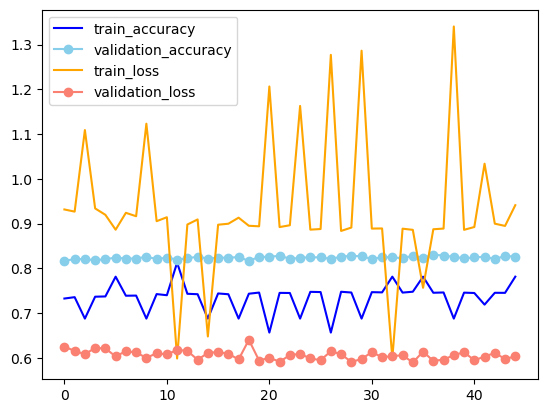

In [66]:
plt.plot(history.epoch, history.history['accuracy'], label='train_accuracy', c='blue')
plt.plot(history.epoch, history.history['val_accuracy'], label='validation_accuracy', c='skyblue', marker='o')
plt.plot(history.epoch, history.history['loss'], label='train_loss', c='orange')
plt.plot(history.epoch, history.history['val_loss'], label='validation_loss', c='salmon', marker='o')
plt.legend()
plt.show()

In [68]:
test_dir2 = "../../../k_food_datasets/test"
test_generator2 = ImageDataGenerator().flow_from_directory(
    test_dir2,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 45000 images belonging to 150 classes.


In [69]:
# 테스트 데이터로 성능 평가 2
test_loss, test_acc = model.evaluate(test_generator2, steps=test_generator.samples // batch_size)

c:\Users\human\.conda\envs\colab\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


328/328 ━━━━━━━━━━━━━━━━━━━━ 1070s 3s/step - accuracy: 0.0918 - loss: 4.5699
